## Feature_Engineering_1
This is an assignment for my thinkful data science course - "Data Cleaning 2"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/Feature_Engineering_1.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Feature_Engineering_1.ipynb) - with all the code exposed in an interactive notebook

In [1]:
#imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox

%matplotlib inline
sns.set_style()

In [2]:
#load data
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine)

engine.dispose()

In [3]:
student_df.head()
student_df.columns.values

array(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'], dtype=object)

### 1. Are the exam score variables distributed normally? If not, apply a Box-Cox transformation. Does anything change?

Before applying box-cox, the p values for Jarque-Bera and Normality tests are well under 0.05, so we must reject the null hypothesis of normality.  

After applying box-cox, the p values for Jarque-Bera and Normality tests are well over 0.05 in all but one case , so we must reject the null hypothesis of normality in those cases.  For the post-b-c writing series, the p-value for the normality test is <.05, while the Jarque-Bera is over .05.   

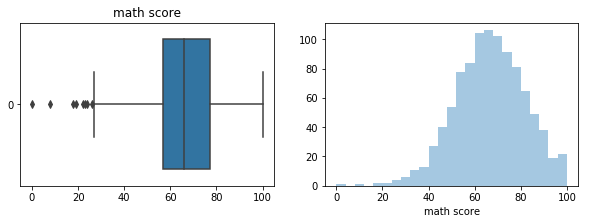

Jarque-Bera test statistics is 15.912256686712709 and p value is 0.0003505075386818213
Normality test statistics is 15.408960513931822 and p value is 0.00045080293869937836


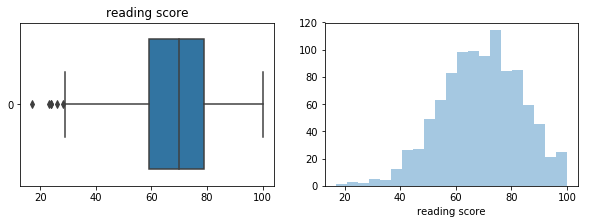

Jarque-Bera test statistics is 11.383300575987892 and p value is 0.0033740202672214448
Normality test statistics is 11.11741279628622 and p value is 0.003853758403576582


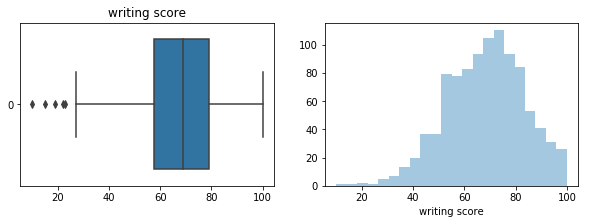

Jarque-Bera test statistics is 13.98509448257235 and p value is 0.0009187033894586527
Normality test statistics is 13.606450837263859 and p value is 0.0011101885439899974


In [4]:
#normality check before Box-Cox
cols = ['math score', 'reading score',
       'writing score']

def assess_normal(df, col_list):
    for col in col_list: 
        plt.figure(figsize=(10, 3))
        plt.subplot(1,2,1)
        sns.boxplot(data=df[col], orient="h")
        plt.title(col)
        plt.subplot(1,2,2)
        sns.distplot(df[col], kde=False)
        plt.show()
        
        jb_stats = jarque_bera(df[col])
        norm_stats = normaltest(df[col])

        print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
        print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

assess_normal(student_df, cols)

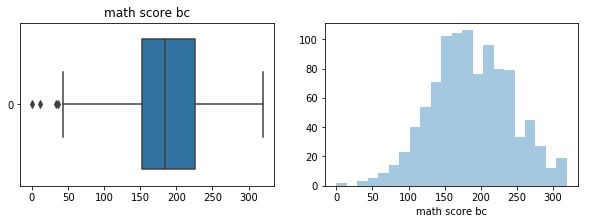

Jarque-Bera test statistics is 0.9589875596660145 and p value is 0.6190967117358159
Normality test statistics is 0.9034198455639313 and p value is 0.636538788347859


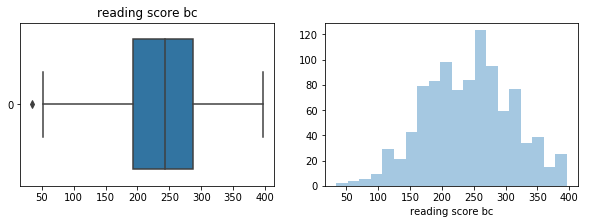

Jarque-Bera test statistics is 4.119778575331906 and p value is 0.1274680814024559
Normality test statistics is 5.282274611852865 and p value is 0.07128015609575467


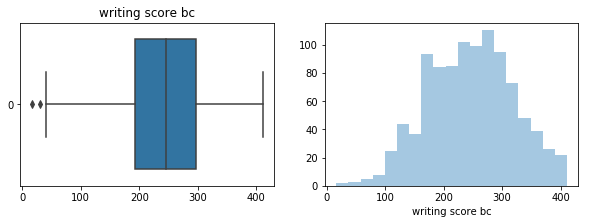

Jarque-Bera test statistics is 4.746478090040098 and p value is 0.09317842784055597
Normality test statistics is 6.267311355043339 and p value is 0.04355827085023795


In [5]:
#normality check after Box-Cox

#replace the one 0 score with a 1, so Box-Cox can be applied
student_df["math score"].replace(to_replace=0,value=1,inplace=True)

student_df["math score bc"],_ = boxcox(student_df["math score"]) 
student_df["reading score bc"],_ = boxcox(student_df["reading score"]) 
student_df["writing score bc"],_  = boxcox(student_df["writing score"])


bc_cols = ['math score bc', 'reading score bc', 'writing score bc']
    
assess_normal(student_df, bc_cols)


### 2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether the transformed variable is normally distributed.

I must reject the null hypothesis that the mean score series is normal before the box-cox (p is <.05 for both tests).

I cannot reject the null hypothesis that the mean score series is normal after the box-cox (p is >.05 for both tests).

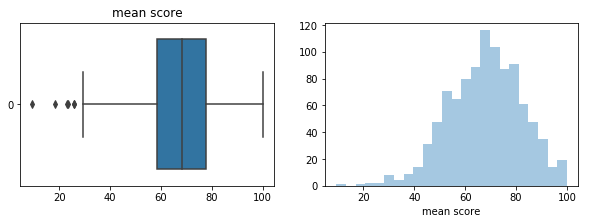

Jarque-Bera test statistics is 15.299648399479786 and p value is 0.0004761278250606793
Normality test statistics is 15.039484104419722 and p value is 0.0005422724257804356


In [6]:
#pre-box mean score normal test
cols_to_mean = student_df[["math score", "reading score", "writing score"]]
student_df["mean score"] = cols_to_mean.mean(axis=1)
a_list = []
assess_normal(student_df, a_list + ["mean score"])

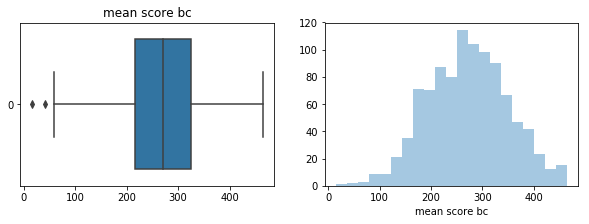

Jarque-Bera test statistics is 2.4521724525282615 and p value is 0.29343878623193853
Normality test statistics is 2.802992852045368 and p value is 0.24622822579114062


In [7]:
#post box-cox mean score normal test
student_df["mean score bc"],_ = boxcox(student_df["mean score"]) 
a_list = []
assess_normal(student_df, a_list + ["mean score bc"])

### 3. Which variables seem to be related with the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

All of the variables appear to have significantly different (p<0.5) mean mean-test-scores at least for some levels.  All of the variables should be considered for a predictive model.  

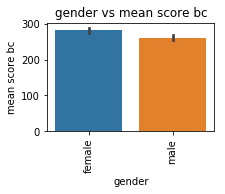

t-test between groups female and male is significant:  p = 1.738268431032557e-05:


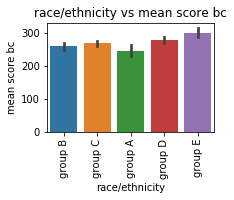

t-test between groups group B and group D is significant:  p = 0.006573764763197138:
t-test between groups group B and group E is significant:  p = 7.71206447682404e-06:
t-test between groups group C and group A is significant:  p = 0.014512815328684422:
t-test between groups group C and group E is significant:  p = 5.7243799047547455e-05:
t-test between groups group A and group D is significant:  p = 0.0003131524682593318:
t-test between groups group A and group E is significant:  p = 1.298676232689196e-06:
t-test between groups group D and group E is significant:  p = 0.009687622135762212:


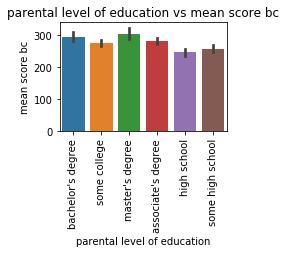

t-test between groups bachelor's degree and some college is significant:  p = 0.026229778918417018:
t-test between groups bachelor's degree and high school is significant:  p = 3.834038851261143e-08:
t-test between groups bachelor's degree and some high school is significant:  p = 9.388512867573486e-05:
t-test between groups some college and master's degree is significant:  p = 0.009760621546134145:
t-test between groups some college and high school is significant:  p = 4.6418832026669074e-05:
t-test between groups some college and some high school is significant:  p = 0.02122588557628826:
t-test between groups master's degree and associate's degree is significant:  p = 0.043644724929200664:
t-test between groups master's degree and high school is significant:  p = 1.6810990356595955e-07:
t-test between groups master's degree and some high school is significant:  p = 0.00011055541552322824:
t-test between groups associate's degree and high school is significant:  p = 1.4261661239102792

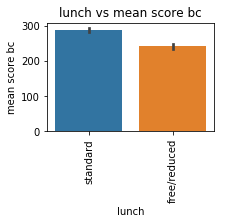

t-test between groups standard and free/reduced is significant:  p = 1.9119280463395854e-20:


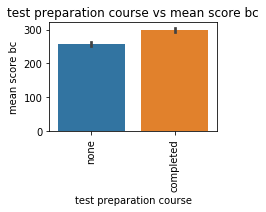

t-test between groups none and completed is significant:  p = 1.1139325473833718e-16:


In [8]:
#t-test for all potential predictive variables
def cat_to_cont(df, cat, cont, threshold):
    """creates a barplot and conducts t-test 
    for a categorical to continuous relationship"""

    #group by
    unique_vals = df[cat].unique()
    grouped_df = df[[cat, cont]].groupby(cat).mean()

    #barplot
    plt.figure(figsize=(3, 2))
    sns.barplot(df[cat], df[cont])
    plt.title("{} vs {}".format(cat, cont))
    plt.xticks(rotation="vertical")
    plt.show()

    #t-test
    for i in range(0, len(unique_vals)):
        for j in range(i+1, len(unique_vals)):
            t, p = stats.ttest_ind(
                df[df[cat]==unique_vals[i]][cont], 
                df[df[cat]==unique_vals[j]][cont])
            if p < threshold: 
                print("t-test between groups {0} and {1} is significant:  p = {2}:"
                      .format(unique_vals[i], unique_vals[j], p))

cats = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"]
for cat in cats:  
    cat_to_cont(student_df, cat, "mean score bc", 0.05)